Iniciando o Fluxo de Potência com Newton-Raphson...
Estado Inicial: V=[1.05 1.   1.03], delta=[0. 0. 0.]

Iteração 1: Mismatch Máximo = 0.393200
Iteração 2: Mismatch Máximo = 0.055423
Iteração 3: Mismatch Máximo = 0.009441
Iteração 4: Mismatch Máximo = 0.001399
Iteração 5: Mismatch Máximo = 0.000037
Iteração 6: Mismatch Máximo = 0.000000

Convergência alcançada em 6 iterações.

--- Resultados Finais ---
Barra 1: V = 1.0500 pu, Delta = 0.0000 graus
Barra 2: V = 0.8188 pu, Delta = -13.3783 graus
Barra 3: V = 1.0300 pu, Delta = 7.1319 graus


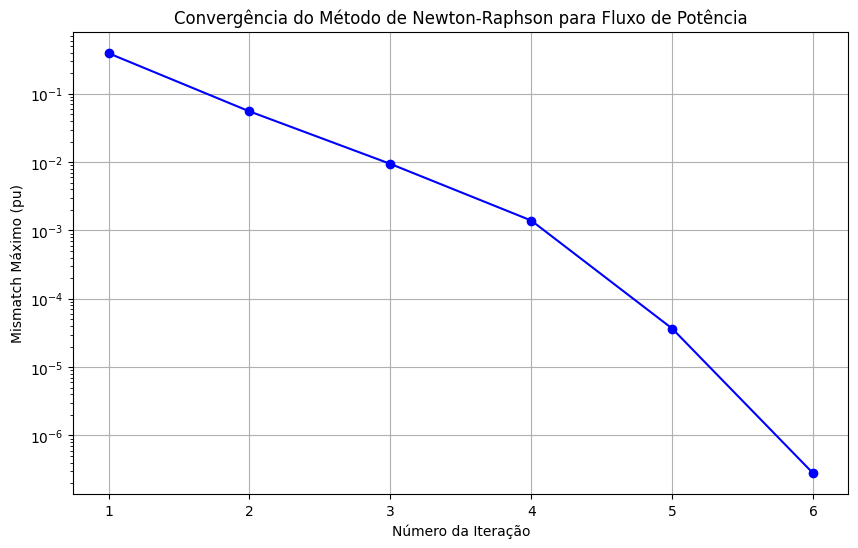

In [ ]:
import numpy as np

# Dados do Sistema Elétrico (em pu)
# Dicionário para os dados das barras
# Tipo 1: Swing, Tipo 2: PQ (Carga), Tipo 3: PV (Geração)
bus_data = {
    1: {'tipo': 1, 'V_esp': 1.05, 'delta_esp': 0},
    2: {'tipo': 2, 'P_esp': -0.4, 'Q_esp': -0.2}, # Carga: potência sai da barra (negativa)
    3: {'tipo': 3, 'P_esp': 0.3, 'V_esp': 1.03}  # Geração: potência entra na barra (positiva)
}

# Dados das linhas (admitâncias Y = G + jB)
# Adicionando uma pequena condutância G para realismo, mas B domina
line_data = {
    (1, 2): 0.1 - 1.0j,
    (1, 3): 0.08 - 0.8j,
    (2, 3): 0.06 - 0.6j
}

# Montagem da Matriz de Admitância (Ybus)
def montar_ybus(bus_data, line_data):
    n_barras = len(bus_data)
    Ybus = np.zeros((n_barras, n_barras), dtype=complex)

    for (i, j), y_ij in line_data.items():
        # Elementos fora da diagonal
        Ybus[i-1, j-1] = -y_ij
        Ybus[j-1, i-1] = -y_ij
        # Contribuição para a diagonal
        Ybus[i-1, i-1] += y_ij
        Ybus[j-1, j-1] += y_ij
    
    # Adicionar shunts se houver (não temos neste exemplo)
    
    return Ybus

# Função Principal: Newton-Raphson para Fluxo de Potência.
def fluxo_potencia_nr(bus_data, line_data, tol=1e-5, max_iter=10):
    n_barras = len(bus_data)
    Ybus = montar_ybus(bus_data, line_data)
    G = Ybus.real
    B = Ybus.imag

    # Inicialização do vetor de estado (V e delta)
    # "Flat Start": tensões 1.0 pu, ângulos 0 rad
    V = np.array([bus_data[i].get('V_esp', 1.0) for i in range(1, n_barras + 1)])
    delta = np.array([bus_data[i].get('delta_esp', 0.0) for i in range(1, n_barras + 1)])

    print("Iniciando o Fluxo de Potência com Newton-Raphson...")
    print(f"Estado Inicial: V={V}, delta={delta}\n")
    
    historico_mismatch = []

    for it in range(max_iter):
        # Cálculo das potências injetadas (P_calc, Q_calc)
        P_calc = np.zeros(n_barras)
        Q_calc = np.zeros(n_barras)
        for i in range(n_barras):
            for j in range(n_barras):
                theta_ij = delta[i] - delta[j]
                P_calc[i] += V[i] * V[j] * (G[i, j] * np.cos(theta_ij) + B[i, j] * np.sin(theta_ij))
                Q_calc[i] += V[i] * V[j] * (G[i, j] * np.sin(theta_ij) - B[i, j] * np.cos(theta_ij))

        # Cálculo do Mismatch (ΔP, ΔQ) 
        # Apenas para barras PQ e PV
        P_esp = np.array([bus_data[i].get('P_esp', 0) for i in range(1, n_barras + 1)])
        Q_esp = np.array([bus_data[i].get('Q_esp', 0) for i in range(1, n_barras + 1)])
        
        # Mismatch Vector (ΔP para barras 2,3 e ΔQ para barra 2)
        # Ordem das incógnitas: [delta2, delta3, V2]
        delta_P2 = P_esp[1] - P_calc[1]
        delta_P3 = P_esp[2] - P_calc[2]
        delta_Q2 = Q_esp[1] - Q_calc[1]
        
        mismatch = np.array([delta_P2, delta_P3, delta_Q2])
        
        # Estabelecendo Critério de Parada
        max_mismatch = np.max(np.abs(mismatch))
        historico_mismatch.append(max_mismatch)
        print(f"Iteração {it+1}: Mismatch Máximo = {max_mismatch:.6f}")
        if max_mismatch < tol:
            print(f"\nConvergência alcançada em {it+1} iterações.")
            return V, delta, historico_mismatch

        # Cálculo da Matriz Jacobiana
        # Submatrizes J11, J12, J21, J22 (derivadas parciais)
        # J11 = dP/dDelta, J12 = dP/dV, etc.
        # As fórmulas são complexas, derivadas das equações de P e Q
        # dP2/dDelta2
        J11_22 = -Q_calc[1] - B[1,1]*V[1]**2
        # dP2/dDelta3
        J11_23 = V[1]*V[2]*(G[1,2]*np.sin(delta[1]-delta[2]) - B[1,2]*np.cos(delta[1]-delta[2]))
        # dP3/dDelta2
        J11_32 = V[2]*V[1]*(G[2,1]*np.sin(delta[2]-delta[1]) - B[2,1]*np.cos(delta[2]-delta[1]))
        # dP3/dDelta3
        J11_33 = -Q_calc[2] - B[2,2]*V[2]**2

        # dP2/dV2
        J12_22 = P_calc[1]/V[1] + G[1,1]*V[1]
        # dQ2/dDelta2
        J21_22 = P_calc[1] - G[1,1]*V[1]**2
        # dQ2/dDelta3
        J21_23 = -V[1]*V[2]*(G[1,2]*np.cos(delta[1]-delta[2]) + B[1,2]*np.sin(delta[1]-delta[2]))
        # dQ2/dV2
        J22_22 = Q_calc[1]/V[1] - B[1,1]*V[1]
        
        # Montando a Jacobiana para nosso sistema 2xPV e 1xPQ
        # A ordem é importante e corresponde ao vetor de mismatch
        J = np.array([
            [J11_22, J11_23, J12_22],
            [J11_32, J11_33, 0],       # dP3/dV2 = 0 pois não há linha direta
            [J21_22, J21_23, J22_22]
        ])
        
        # Resolução do sistema linear e atualização
        # Resolve J * delta_x = mismatch ao invés de inverter J (mais estável)
        correcao = np.linalg.solve(J, mismatch)
        
        # Atualiza o vetor de estado
        delta[1] += correcao[0]  # delta2
        delta[2] += correcao[1]  # delta3
        V[1] += correcao[2]      # V2
        
    print("O método não convergiu após o número máximo de iterações.")
    return V, delta, historico_mismatch


#  Execução e Resultados 
V_final, delta_final, historico = fluxo_potencia_nr(bus_data, line_data)

print("\n--- Resultados Finais ---")
for i in range(len(V_final)):
    print(f"Barra {i+1}: V = {V_final[i]:.4f} pu, Delta = {np.rad2deg(delta_final[i]):.4f} graus")

# Plot do comportamento da convergência
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(historico) + 1), historico, 'o-', color='b')
plt.xlabel('Número da Iteração')
plt.ylabel('Mismatch Máximo (pu)')
plt.title('Convergência do Método de Newton-Raphson para Fluxo de Potência')
plt.grid(True)
plt.yscale('log') # Escala logarítmica é ótima para ver a convergência rápida
plt.xticks(range(1, len(historico) + 1))
plt.show()